# EXPERIMENT 1
---
### Model Architecture: Directional LSTM
### Dataset: Milan (Take medicine / Binary classification)

### Parameters
- INPUT_DIM = 120
- N_HIDDEN = 64
- MAX_LENGTH = 2000 (fixed)
- NO_ACTIVITIES = 2
- OPTIMIZER = ADAM
- TOTAL EPOCHS = 30


In [1]:
from google.colab import drive
drive.mount('/content/drive/')
#imports
import os 
import pickle
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#tensorflow
import tensorflow as tf
from keras.layers import Dense, LSTM, Bidirectional, RNN
from keras.layers.embeddings import Embedding
from keras.models import Sequential
DATA_PATH = '/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/PP_Data/'

Mounted at /content/drive/


In [43]:
def getData(datasetName):
    X = np.load(f"{DATA_PATH}{datasetName}_X_Single.npy", allow_pickle=True)
    Y = np.load(f"{DATA_PATH}{datasetName}_Y_Single.npy", allow_pickle=True)
    enc_dec = np.load(f"{DATA_PATH}/{datasetName}_ENCDEC_Single.npy", allow_pickle=True)
    return X, Y, enc_dec
X, y, (idx2act, idx2obs, act2idx, obs2idx) = getData('milan')

In [45]:
unique_elements, counts_elements = np.unique(y, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))
print(len(X))
print(len(y))

Frequency of unique values of the said array:
[[0 1]
 [60 60]]
120
120


In [15]:
import random

In [44]:
idxs = []
for i, val in enumerate(y):
  if not val:
    idxs.append(i)
selects = np.random.permutation(len(idxs))[:-60]
idxs_to_drop = [idxs[i] for i in selects]

X = np.delete(X, idxs_to_drop, axis=0)
y = np.delete(y, idxs_to_drop)

In [4]:
def get_class_acc(X, y, model, idx2act):
  preds = np.array(np.argmax(model.predict(X, verbose=1), axis=-1), dtype=np.int32)
  targets = np.array(y, dtype=np.int32)
  
  print("Classwise accuracy: ")
  totals = {}
  correct = {}
  for i in range(len(idx2act)):
    totals[i] = 1
    correct[i] = 0
  for each in targets: 
    totals[each]+=1
  for i in range(len(idx2act)):
    if totals[i] != 1:
      totals[i] -= 1
  for i, each in enumerate(preds): 
    if each == targets[i]:
        correct[each]+=1
  for i, each in enumerate(idx2act):
    print(f"Model accuracy for predicting {each}: {correct[i]}/{totals[i]} || {round(correct[i]/totals[i]*100, 2)}%")

  print('-'*120)
  m = confusion_matrix(targets, preds)
  fig, ax = plt.subplots(figsize=(23,20))
  sns.heatmap(m, annot=True, ax=ax)
  ax.set(xticklabels=idx2act, yticklabels=idx2act)
  plt.show()
  print('-'*120)

In [5]:
def plot_history(dict):
  # summarize history for accuracy
  plt.figure(figsize=(10,10))
  plt.plot(dict['accuracy'])
  plt.plot(dict['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(10,10))
  plt.plot(dict['loss'])
  plt.plot(dict['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

In [7]:
def run(X, y, idx2act, model, save_as, EPOCHS=10):
  print("-"*100)
  print(" > REPORT")
  print("-"*100)
  # TEST SPLIT
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

  print('Training set distribution')
  fig, ax = plt.subplots(figsize=(20,5))
  train_y_df = pd.DataFrame({'y' : np.array(y_train, dtype=np.float32)})
  sns.countplot(train_y_df.y, ax=ax)
  ax.set(xticklabels=idx2act)
  plt.xticks(rotation=45)
  plt.show()
  print('Test set distribution')
  fig2, ax2 = plt.subplots(figsize=(20,5))
  test_y_df = pd.DataFrame({'y' : np.array(y_test, dtype=np.float32)})
  sns.countplot(test_y_df.y, ax=ax2)
  ax2.set(xticklabels=idx2act)
  plt.xticks(rotation=45)
  plt.show()
  
  print('Activity accuracy training set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_train, dtype=np.float32)), tf.convert_to_tensor(np.array(y_train, dtype=np.float32)), model, idx2act)
  print()
  print('Activity accuracy test set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), model, idx2act)
  
  # KFOLD SETUP
  X_train_np = np.array(X_train, dtype=np.float32)
  y_train_np = np.array(y_train, dtype=np.float32)
  skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
  # KFOLD LOOP
  overall_acc = []
  
  agg_hist={'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
  for i, (train, test) in enumerate(skf.split(X_train_np, y_train_np)):
    print(f'Fold >> {i+1}')
    X_train_ = tf.convert_to_tensor(X_train_np[train], dtype=tf.float32)
    Y_train_ = tf.convert_to_tensor(y_train_np[train], dtype=tf.float32)
    X_test_ = tf.convert_to_tensor(X_train_np[test], dtype=tf.float32)
    Y_test_ = tf.convert_to_tensor(y_train_np[test], dtype=tf.float32)
    print(f"Begin training ...")

    filepath = f"/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/Experiments/Models/{save_as}"
    history = model.fit(X_train_, Y_train_, epochs=EPOCHS, batch_size=64, verbose=1, callbacks=[], validation_split=0.2)
    agg_hist['loss'].extend(history.history['loss'])
    agg_hist['val_loss'].extend(history.history['val_loss'])
    agg_hist['accuracy'].extend(history.history['accuracy'])
    agg_hist['val_accuracy'].extend(history.history['val_accuracy'])
    print(f"Begin evalutaion ...")
    scores = model.evaluate(X_test_, Y_test_, batch_size=64, verbose=1)
    print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
    overall_acc.append(scores[1]*100)
    print()

  model.save(filepath+".h5")
  print('HISTORY')
  plot_history(agg_hist)
  print()

  print('Test set evalutaion')
  scores = model.evaluate(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), batch_size=64, verbose=1)
  print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
  print()
  print('Activity accuracy training set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_train, dtype=np.float32)), tf.convert_to_tensor(np.array(y_train, dtype=np.float32)), model, idx2act)
  print()
  print('Activity accuracy test set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), model, idx2act)

In [46]:
# biLSTM 
def get_biLSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER):
  model = Sequential(name='biLSTM')
  model.add(Embedding(INPUT_DIM, N_HIDDEN, input_length=MAX_LENGTH, mask_zero=True))
  model.add((LSTM(N_HIDDEN)))
  model.add(Dense(NO_ACTIVITIES, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
  model.summary()
  return model

In [47]:
#Arbitary high dim
INPUT_DIM = 120 
#2n
N_HIDDEN = 64
MAX_LENGTH = 2000
NO_ACTIVITIES = len(idx2act)
OPTIMIZER = 'adam'

In [48]:
model = get_biLSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER)

Model: "biLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 64)          7680      
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 40,834
Trainable params: 40,834
Non-trainable params: 0
_________________________________________________________________


----------------------------------------------------------------------------------------------------
 > REPORT
----------------------------------------------------------------------------------------------------
Training set distribution


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


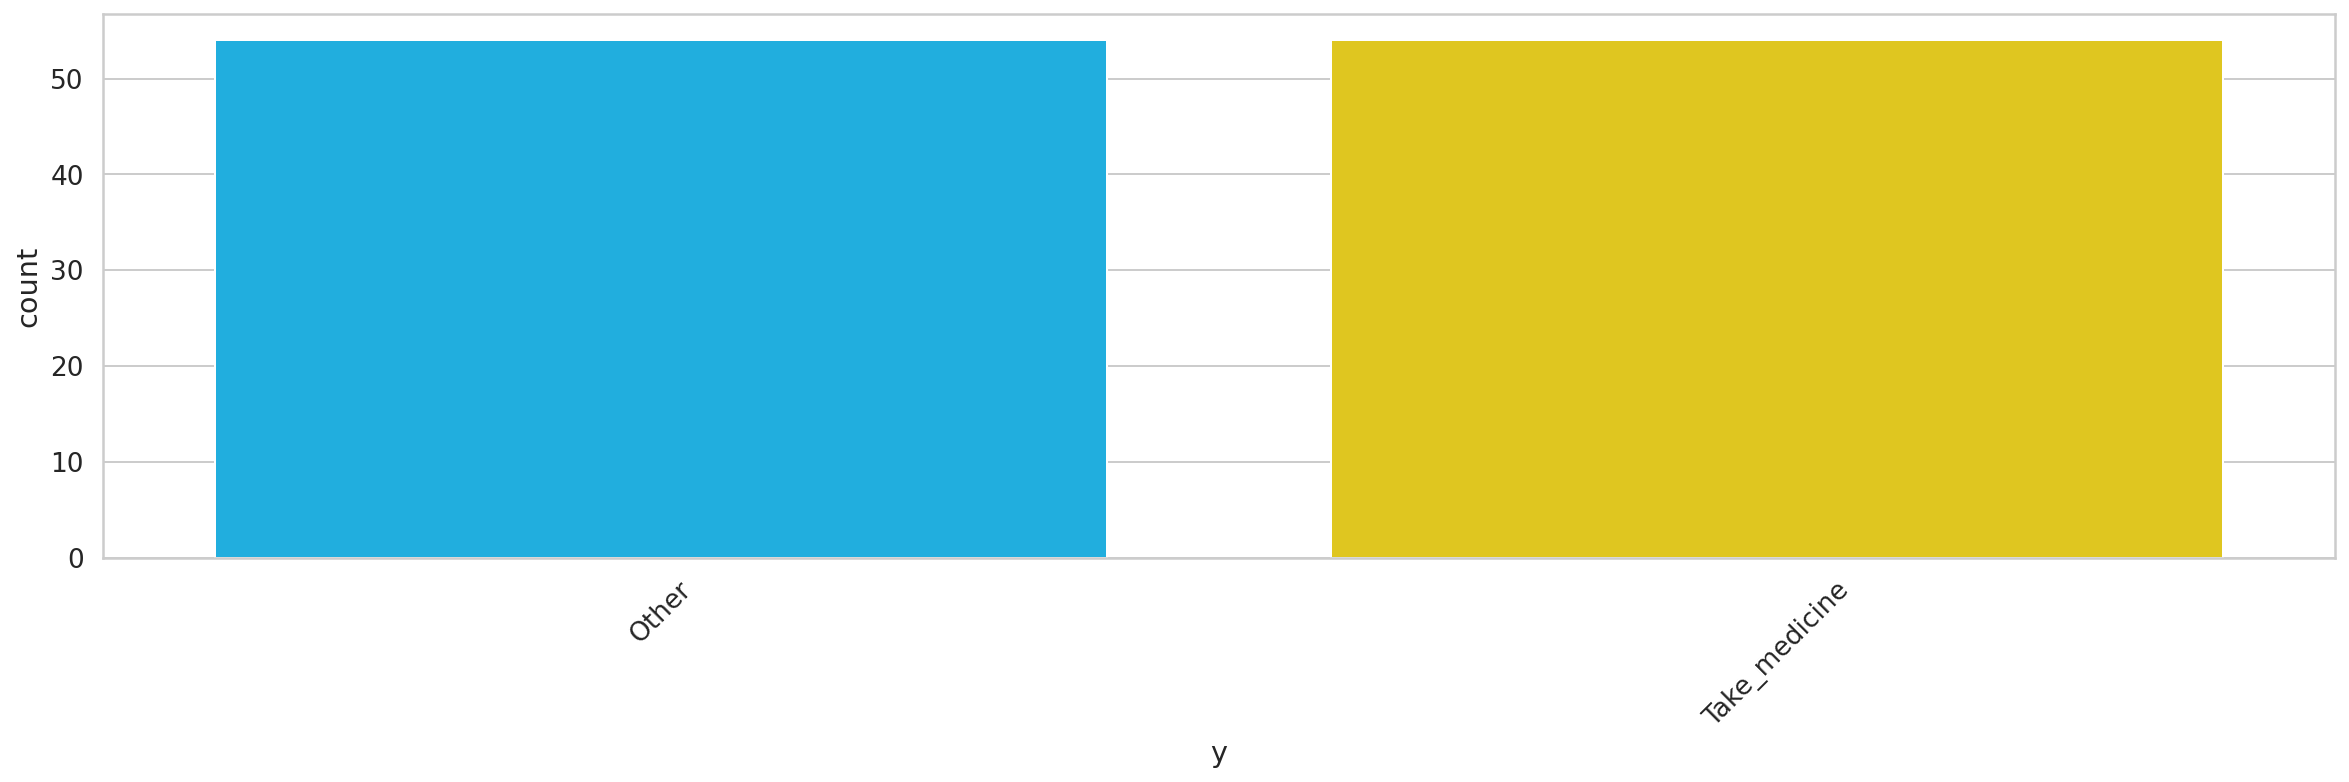

Test set distribution


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


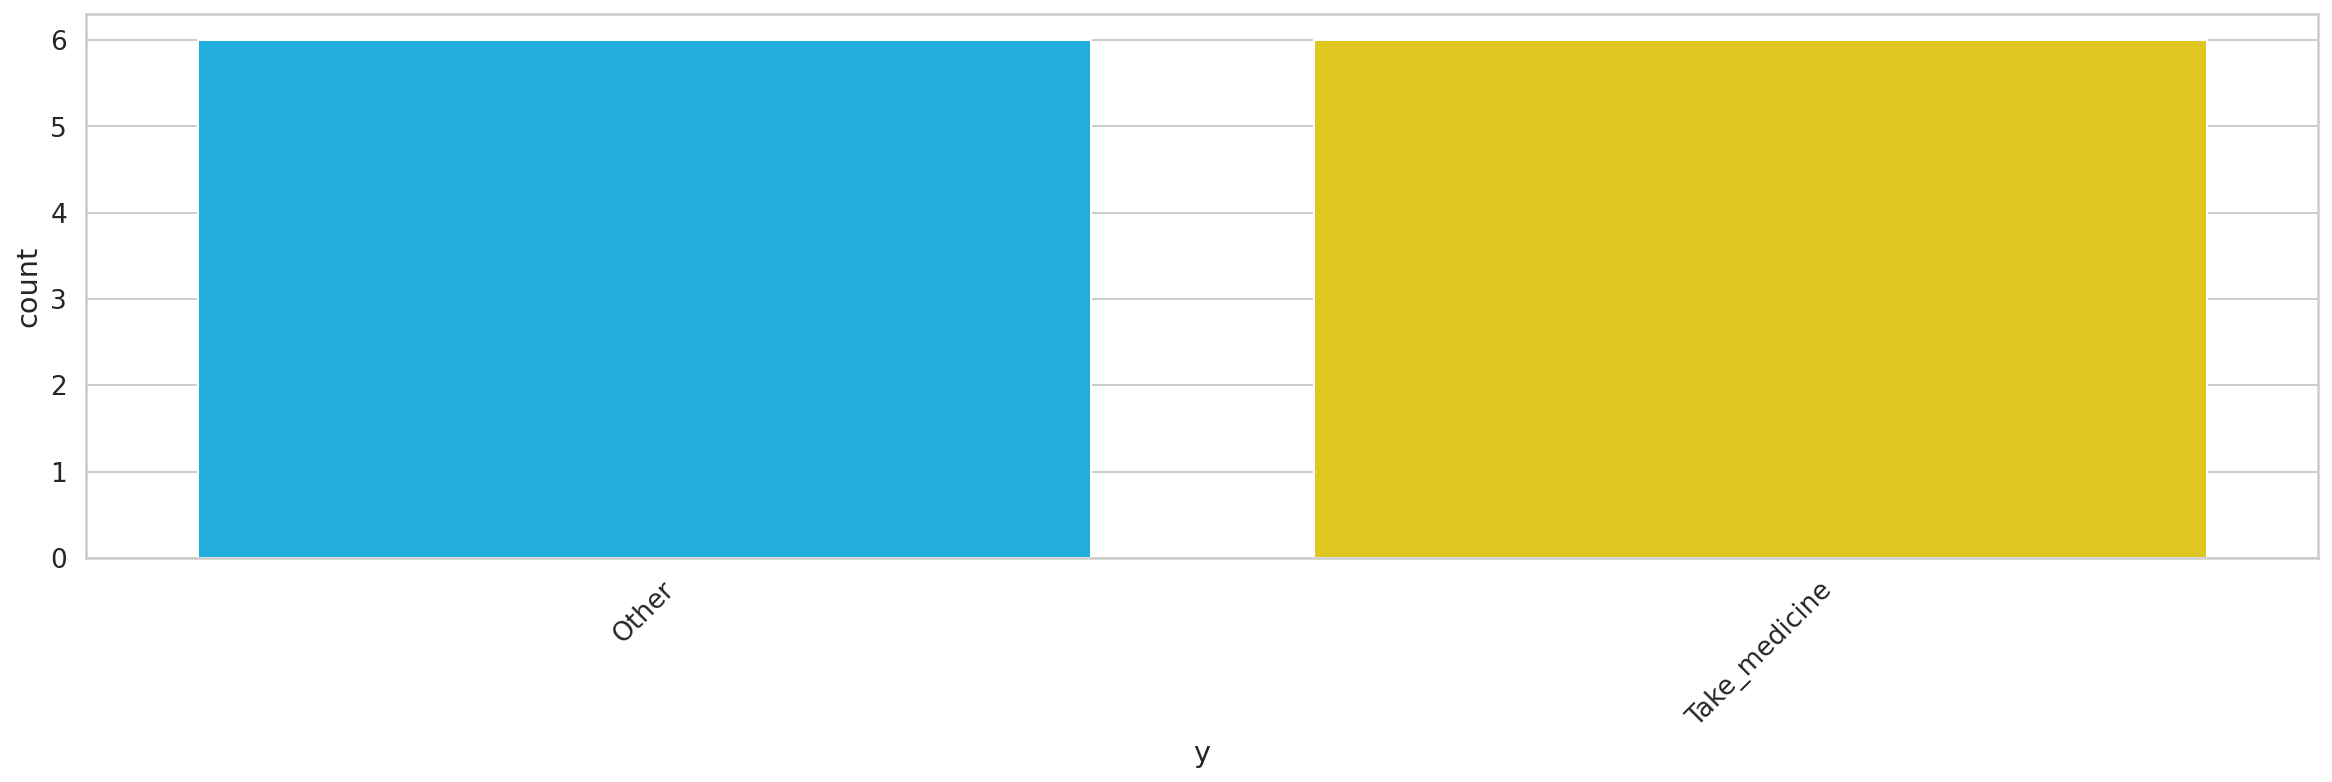

Activity accuracy training set
--------------------------------------------------------------------------------
4/4 [==============================] - 1s 221ms/step
Classwise accuracy: 
Model accuracy for predicting Other: 12/54 || 22.22%
Model accuracy for predicting Take_medicine: 51/54 || 94.44%
------------------------------------------------------------------------------------------------------------------------


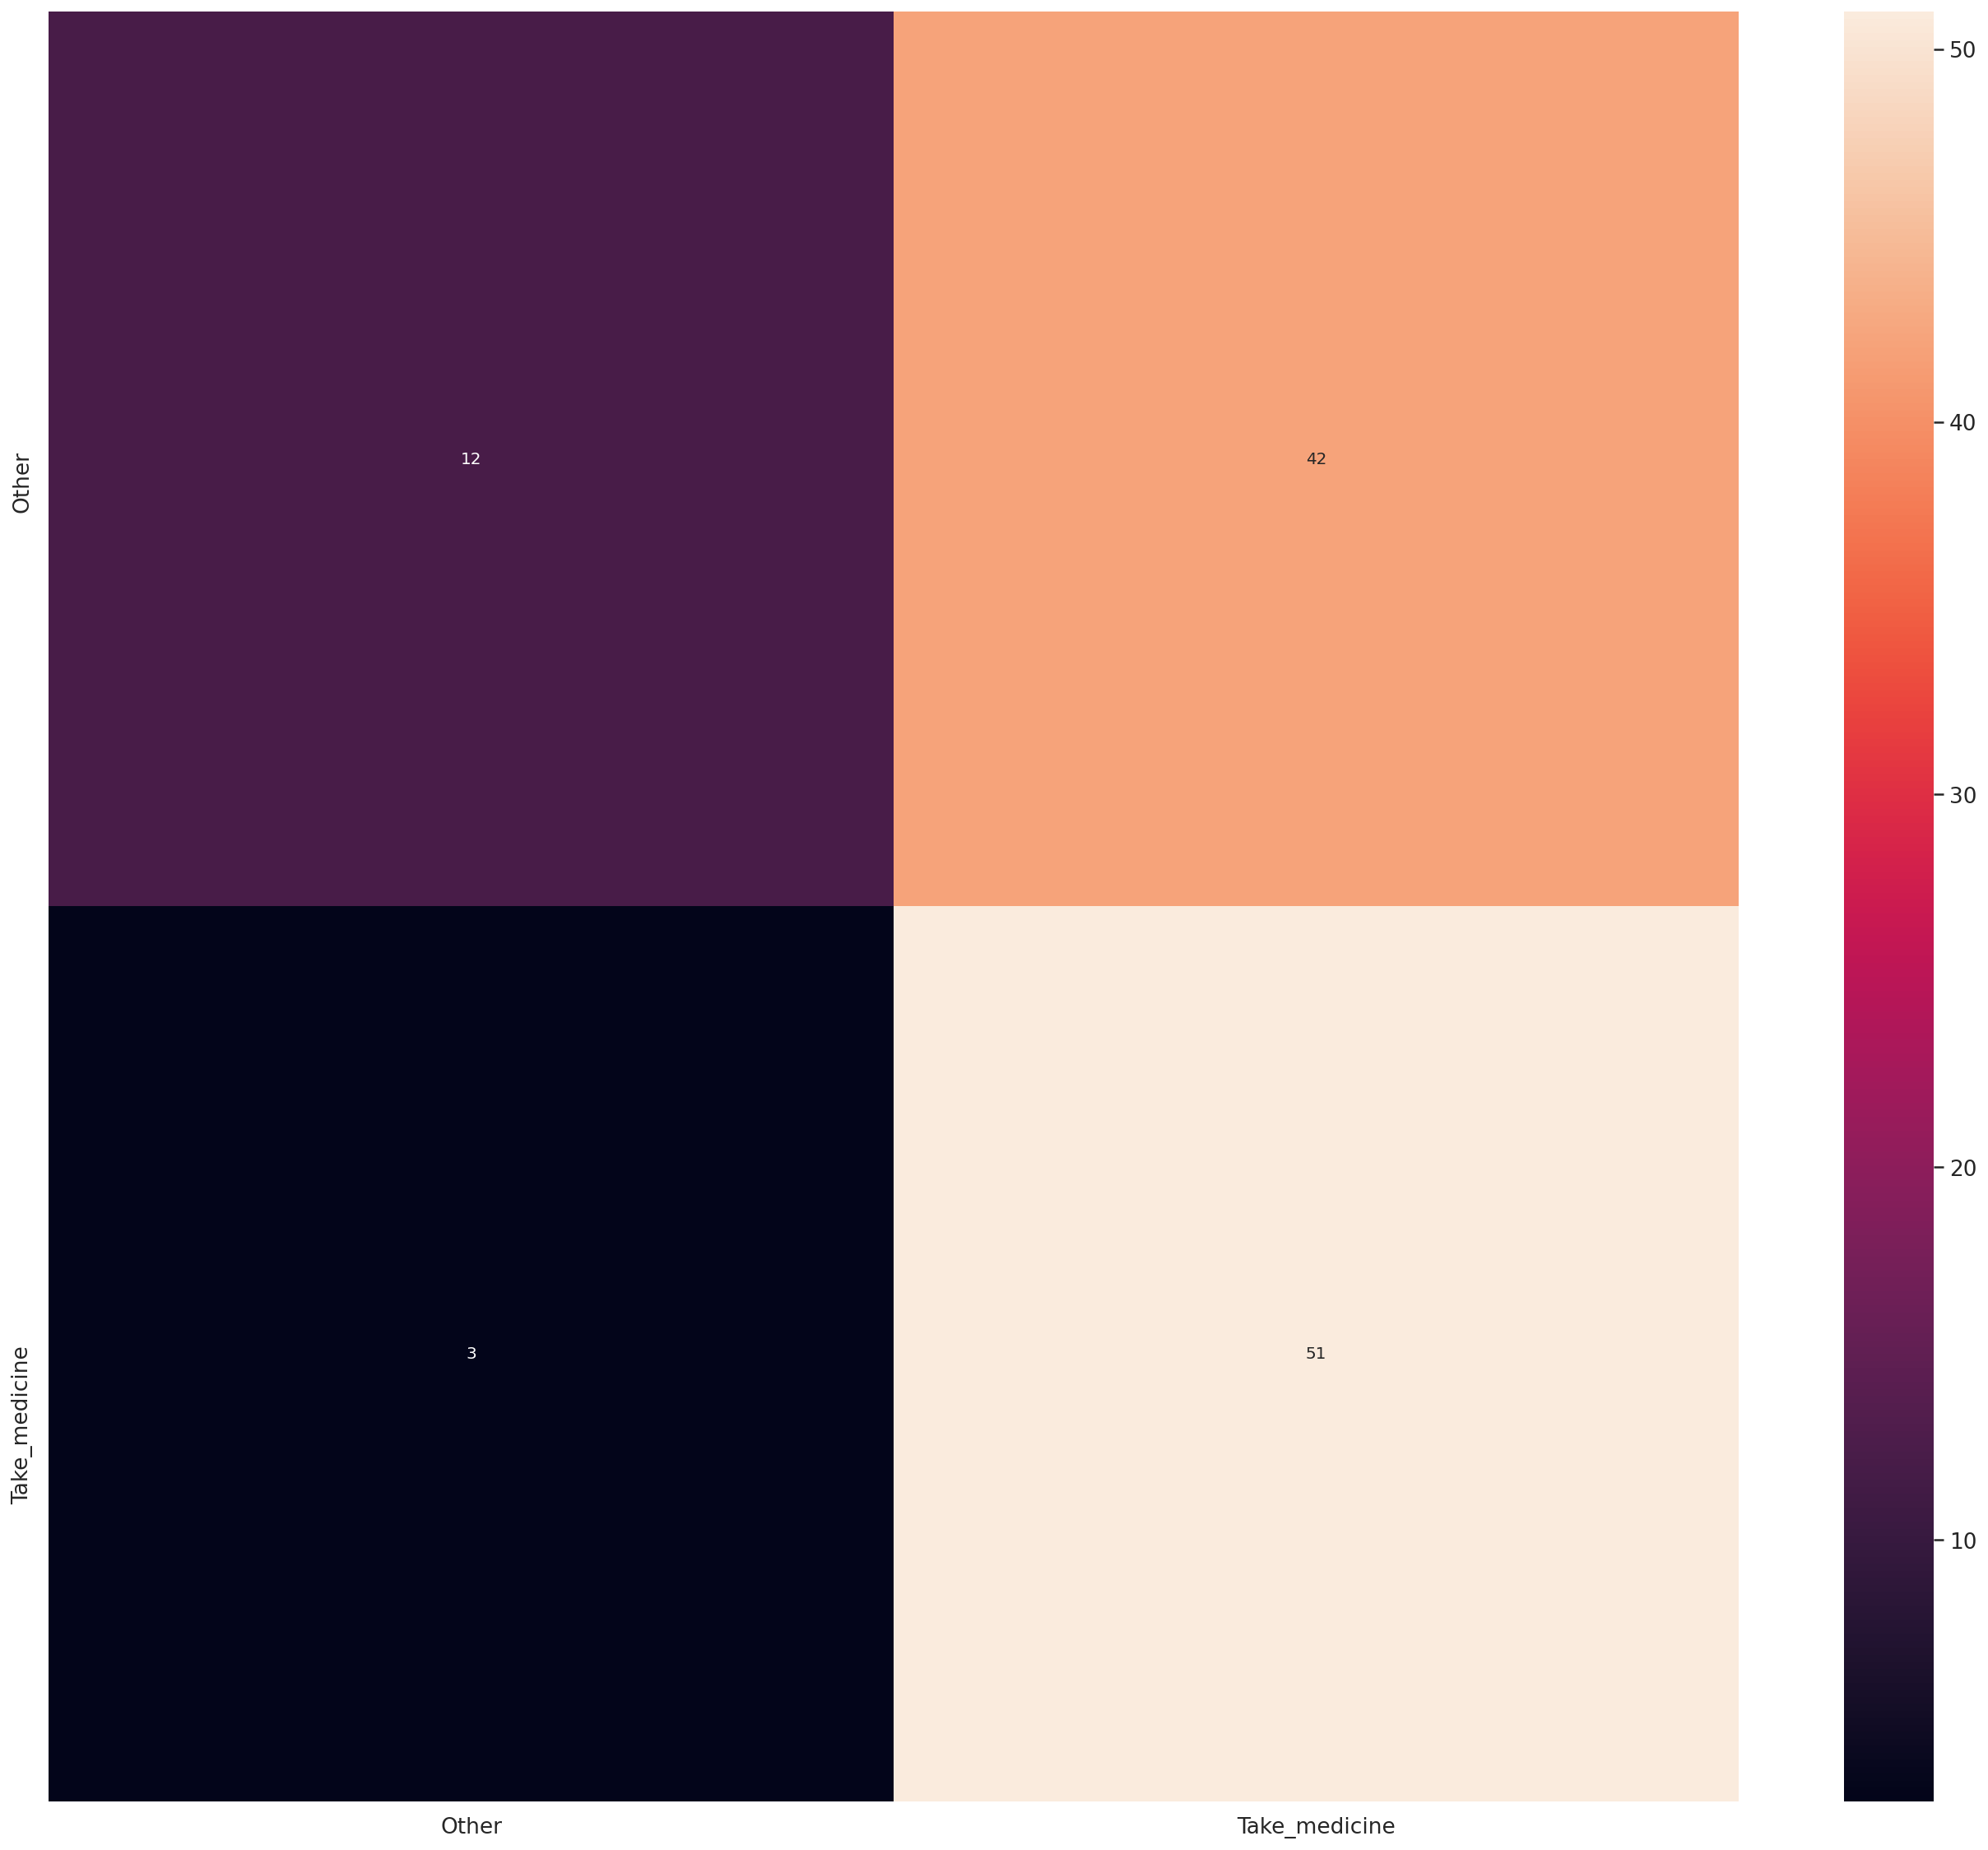

------------------------------------------------------------------------------------------------------------------------

Activity accuracy test set
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 2ms/step
Classwise accuracy: 
Model accuracy for predicting Other: 1/6 || 16.67%
Model accuracy for predicting Take_medicine: 6/6 || 100.0%
------------------------------------------------------------------------------------------------------------------------


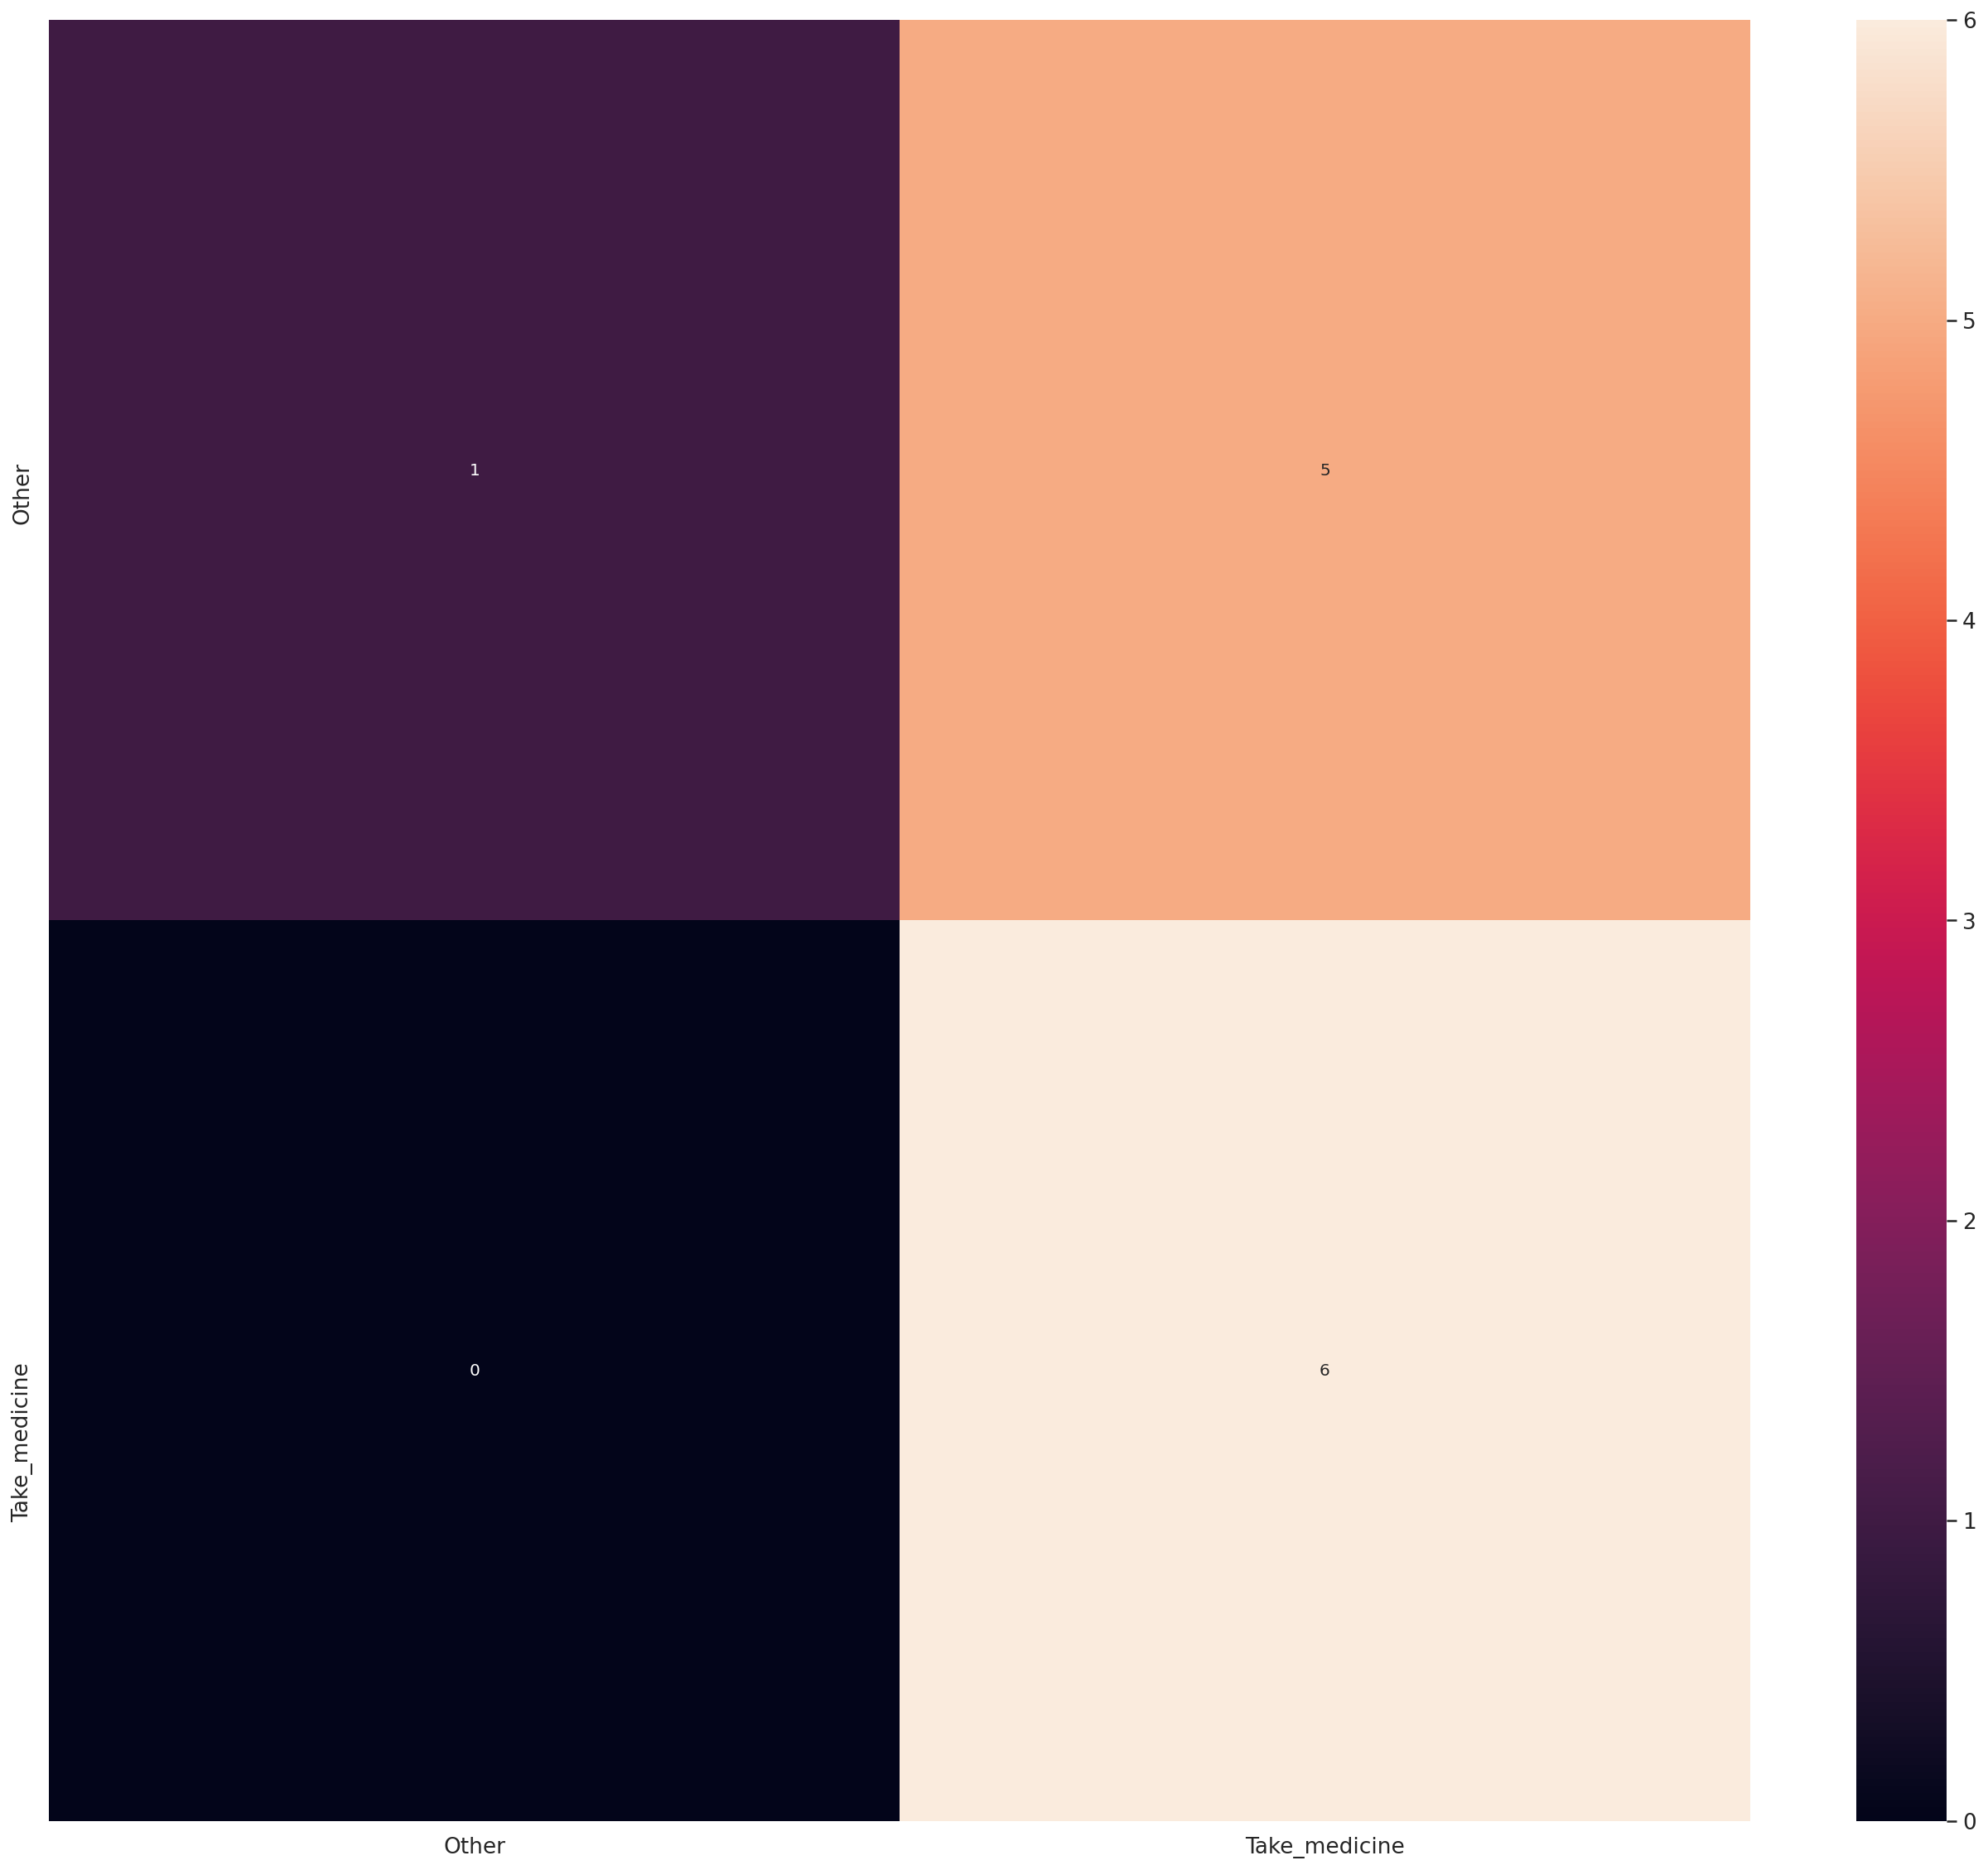

------------------------------------------------------------------------------------------------------------------------
Fold >> 1
Begin training ...
Epoch 1/6
2/2 [==============================] - 5s 3s/step - loss: 0.6932 - accuracy: 0.5735 - val_loss: 0.6932 - val_accuracy: 0.3333
Epoch 2/6
2/2 [==============================] - 4s 2s/step - loss: 0.6932 - accuracy: 0.4265 - val_loss: 0.6932 - val_accuracy: 0.2778
Epoch 3/6
2/2 [==============================] - 4s 2s/step - loss: 0.6932 - accuracy: 0.3529 - val_loss: 0.6932 - val_accuracy: 0.3889
Epoch 4/6
2/2 [==============================] - 4s 2s/step - loss: 0.6932 - accuracy: 0.4265 - val_loss: 0.6932 - val_accuracy: 0.3889
Epoch 5/6
2/2 [==============================] - 4s 2s/step - loss: 0.6932 - accuracy: 0.3088 - val_loss: 0.6932 - val_accuracy: 0.4444
Epoch 6/6
2/2 [==============================] - 4s 2s/step - loss: 0.6932 - accuracy: 0.3235 - val_loss: 0.6932 - val_accuracy: 0.4444
Begin evalutaion ...
1/1 [========

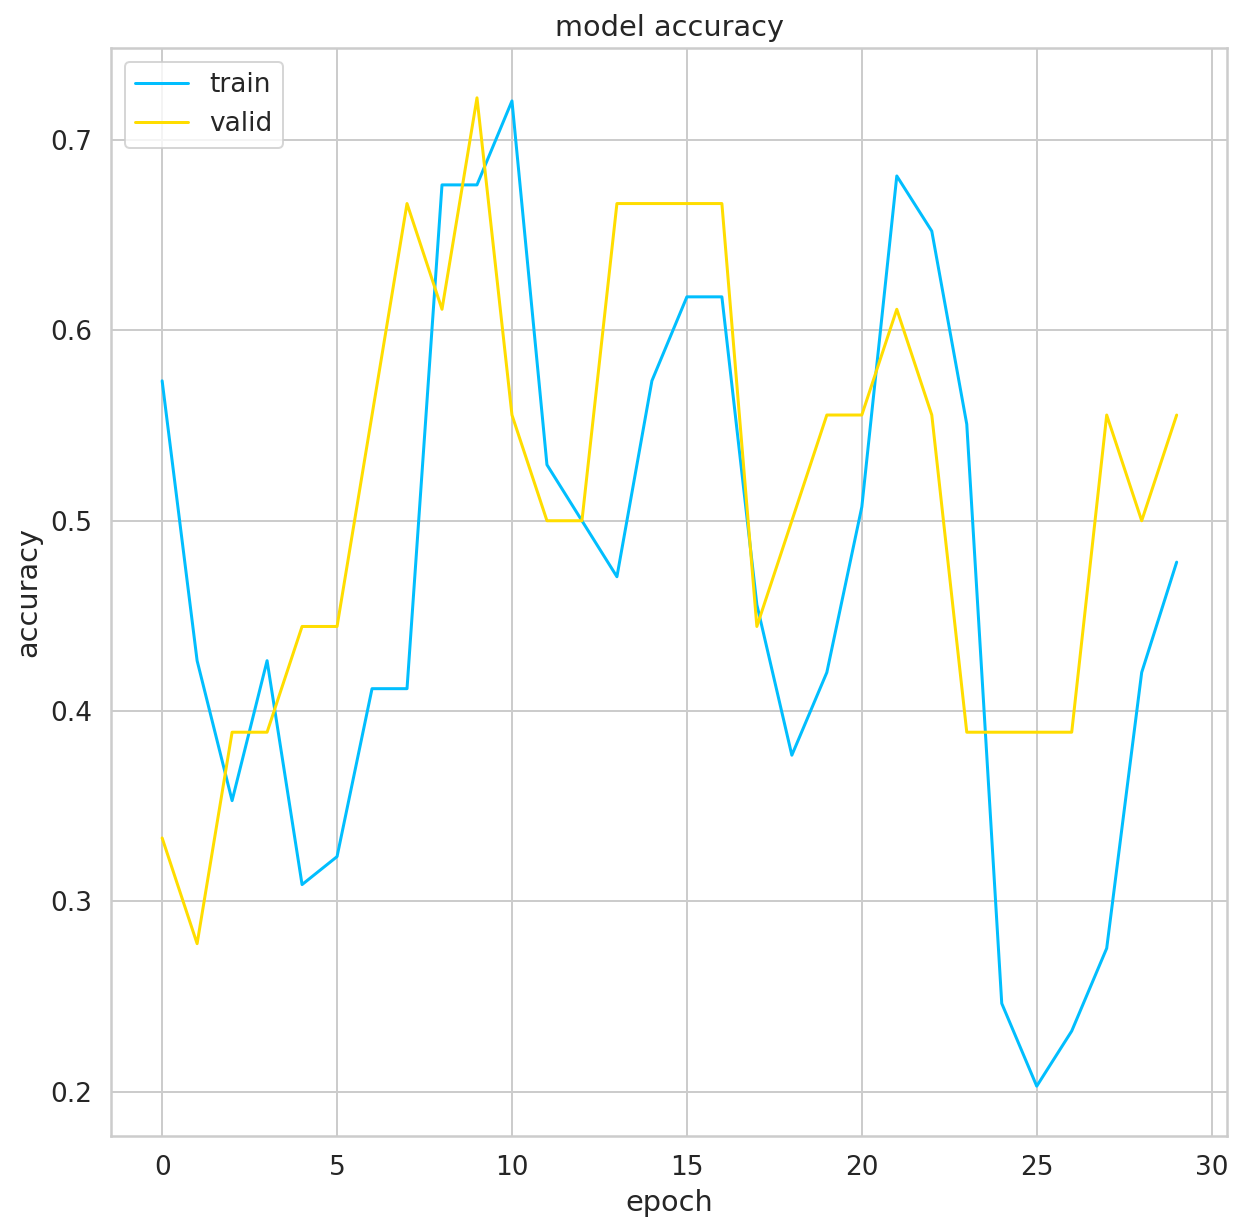

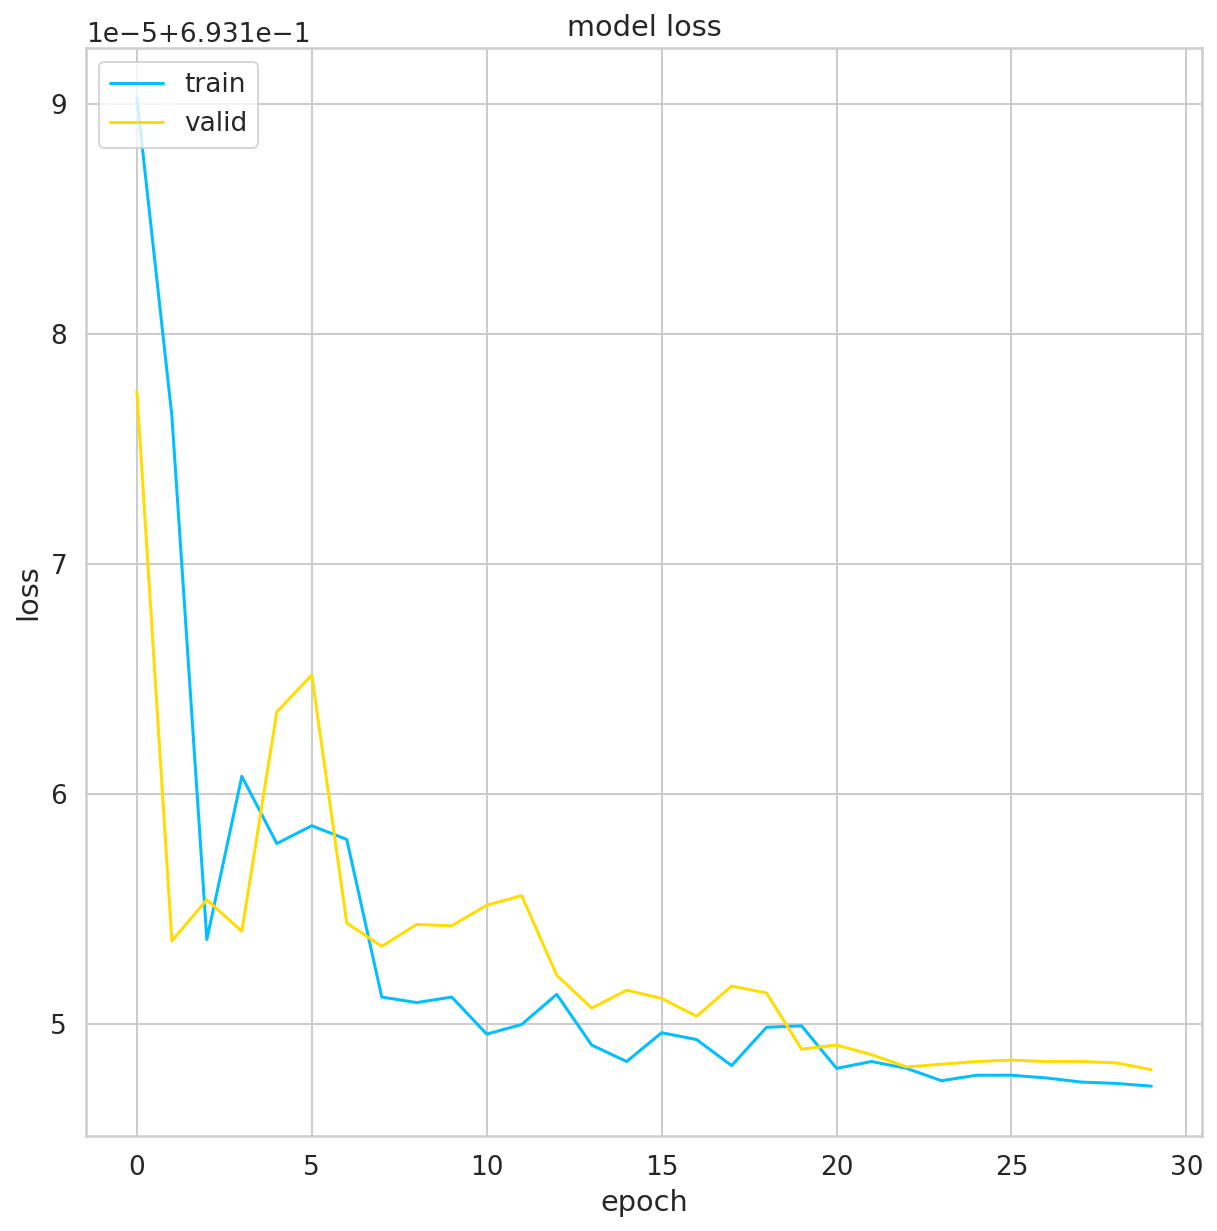


Test set evalutaion
1/1 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.6667
accuracy: 66.67%

Activity accuracy training set
--------------------------------------------------------------------------------
4/4 [==============================] - 1s 231ms/step
Classwise accuracy: 
Model accuracy for predicting Other: 29/54 || 53.7%
Model accuracy for predicting Take_medicine: 31/54 || 57.41%
------------------------------------------------------------------------------------------------------------------------


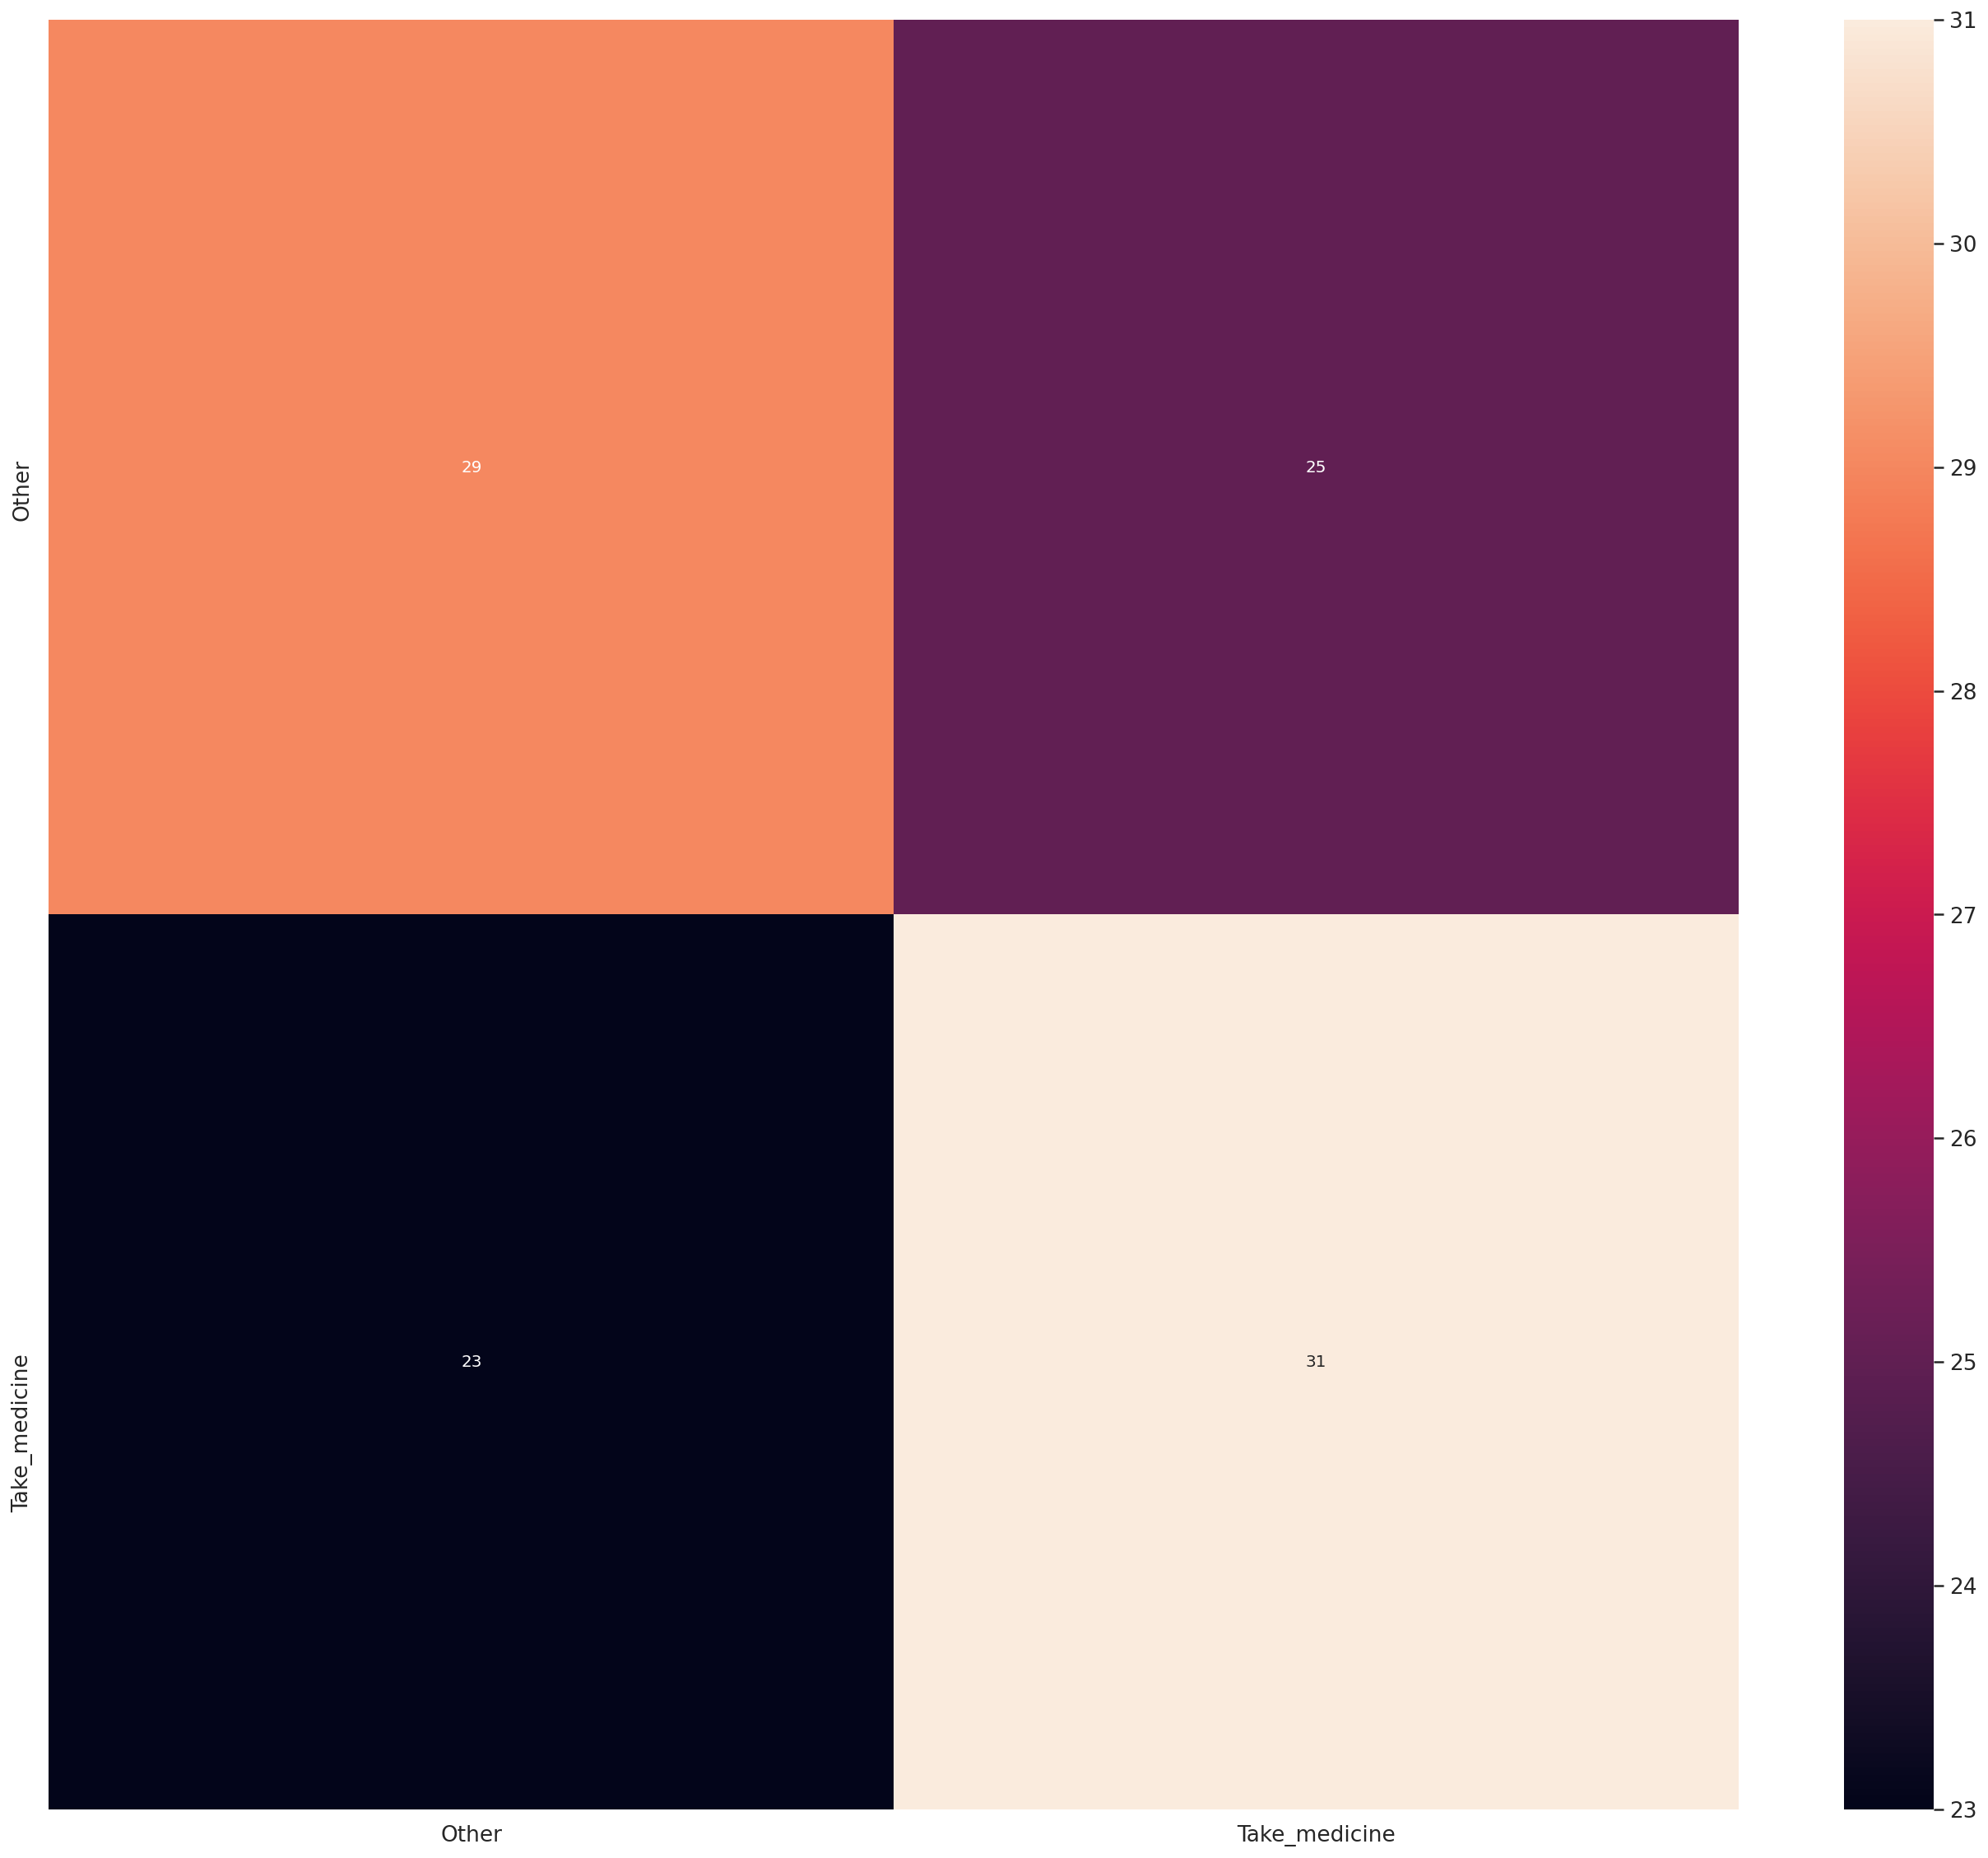

------------------------------------------------------------------------------------------------------------------------

Activity accuracy test set
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 2ms/step
Classwise accuracy: 
Model accuracy for predicting Other: 5/6 || 83.33%
Model accuracy for predicting Take_medicine: 3/6 || 50.0%
------------------------------------------------------------------------------------------------------------------------


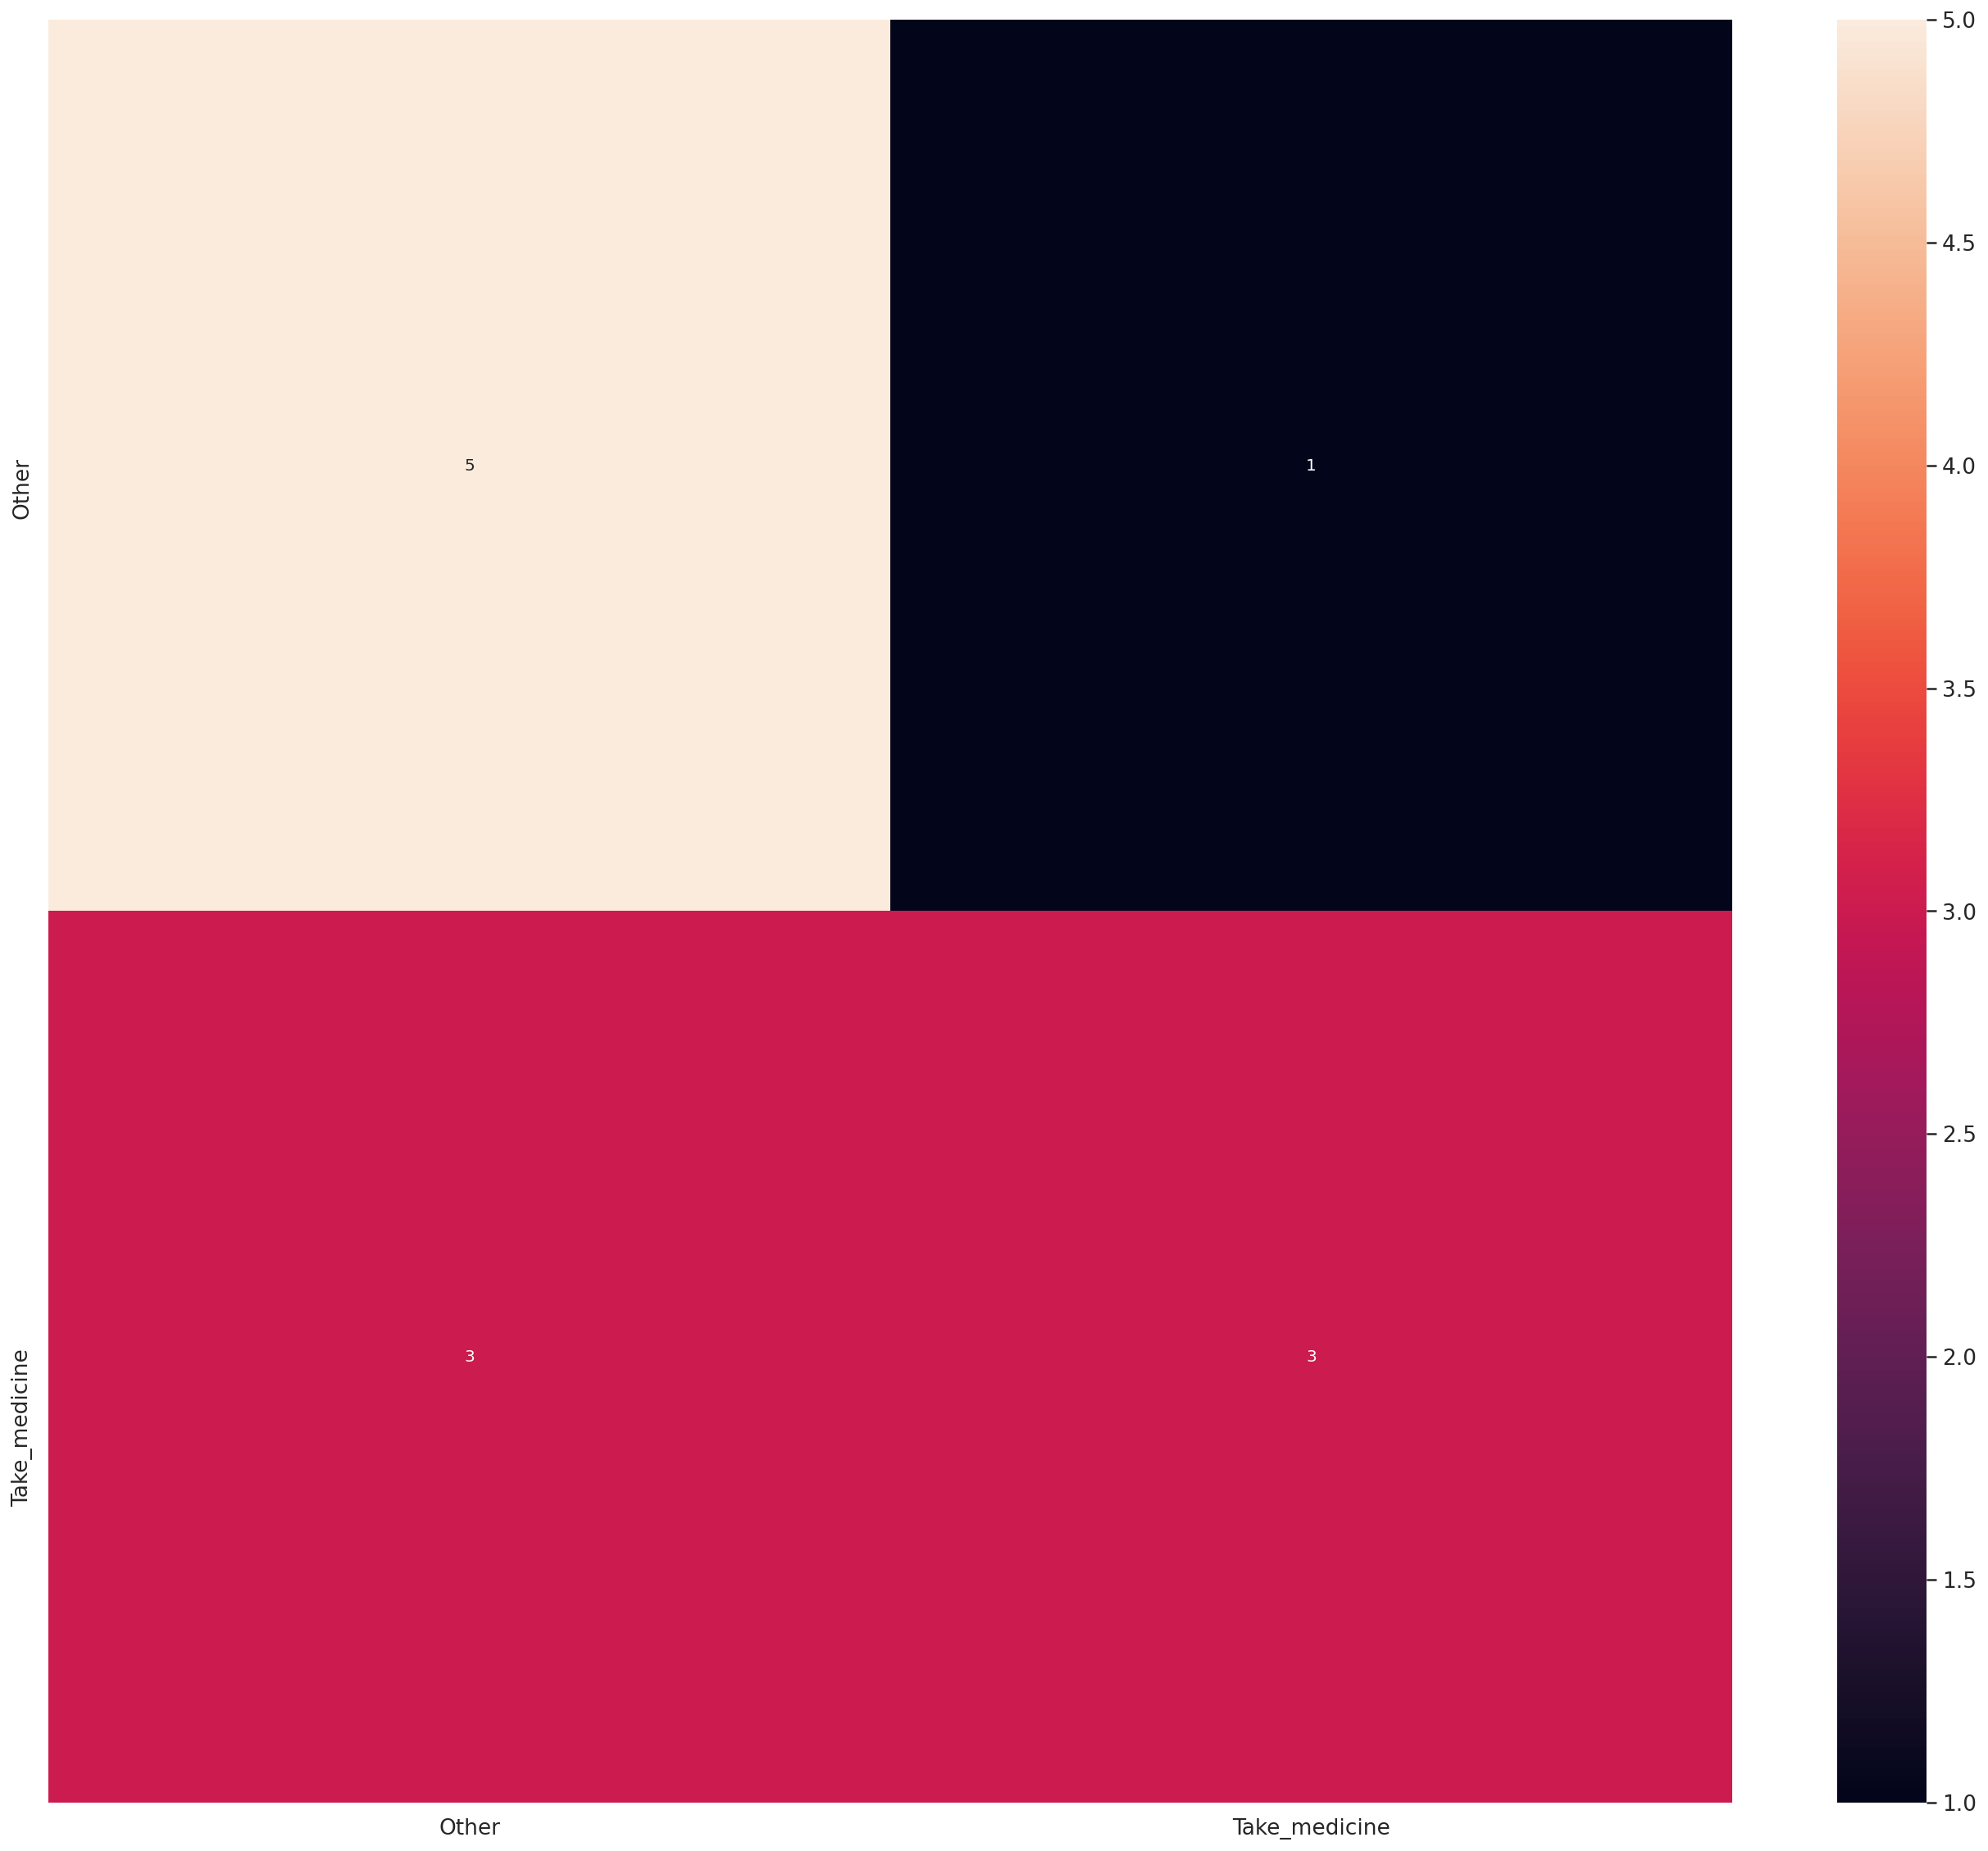

------------------------------------------------------------------------------------------------------------------------


In [49]:
#GO
run(X, y, idx2act, model, 'biLSTM_EP1', 6)